# NTDS assignment 2: network models
[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), *PhD student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

For this assignment we will work on a network representing the collaboration between scientists in the field of General Relativity and Quantum Cosmology. The network comes from [SNAP](http://snap.stanford.edu/data/ca-GrQc.html) and is described as follows:

> Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print [arXiv](https://arxiv.org) and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author *i* co-authored a paper with author *j*, the graph contains a undirected edge from *i* to *j*. If the paper is co-authored by *k* authors this generates a completely connected (sub)graph on *k* nodes. The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv.

In [1]:
%matplotlib inline

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
G = nx.read_edgelist(os.path.join('..', 'data', 'arxiv_collaboration_network.txt'))

In [3]:
print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 5242 nodes.
My network has 14496 edges.


## 1. Comparing to model networks

1.1 In this part of the assignment, you have to create an Erdős–Rényi and Barabási-Albert graph using NetworkX, and compare them to the collaboration network. Try to simulate the original network as best as you can. When choosing parameters for the networks, take into account the number of vertices and edges of the original network. The number of vertices should be exactly the same. Comment on your choice of parameters.

In [4]:
er=nx.erdos_renyi_graph(5242,0.00106)
ba=nx.barabasi_albert_graph(5242, 3)

**Your answer here.**  The probability for erdos_renyi_graph is $\frac{L}{0.5(N-1)N}$=0.00106    And the parameter in barabasi_albert_graph is $\frac{14496}{5242}=2.77$, so we chose 3

In [5]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

My Erdős–Rényi network has 5242 nodes.
My Erdős–Rényi network has 14670 edges.
My Barabási-Albert network has 5242 nodes.
My Barabási-Albert network has 15717 edges.


1.2 Check the size of the largest connected component in each graph and compare them to the original network. In the Erdős–Rényi model, what should the probability of creating each edge be in order to have the same expected size of the largest component? Justify. Generate a graph with this parameter to check if you indeed get a similar value.

In [6]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

4158
5222
5242


**Your answer here.**  We should use the formula $S=1-e^{-<k>S}$,$<k>=p(N-1)$,$S=\frac{N_G}{N}$,and$N_G=4158,N=5242$

In [7]:
import math
S=4158.0/5242
p_giant=math.log((1-S),math.e)*(-1.0)/S/5241

print('The parameter p for an Erdős–Rényi network with the same expected size of the giant component is {}.'.format(p_giant))

er_2=nx.erdos_renyi_graph(5242,p_giant)
er_giant=max(nx.connected_component_subgraphs(er_2), key=len)
print('The size of the component in a randomly generated network with this parameter is {}.'.format(len(er_giant.nodes())))

The parameter p for an Erdős–Rényi network with the same expected size of the giant component is 0.000379111572025.
The size of the component in a randomly generated network with this parameter is 4134.


1.3 Look at the clustering coefficient of the original network. Is there a network model we talked about that could have a clustering coefficient that is close? Explain.

In [8]:
print (nx.average_clustering(G))
print (nx.average_clustering(er))
print (nx.average_clustering(ba))

0.529635811052
0.00129041440564
0.00955404641375


**Your answer here.** No, because random network model never capture the clustering of real networks.Usually, real networks have a much higher clustering coeffcient than predicted.

## 2. Creating a network with a predefined degree distribution

In this part of the assignment, you will have to create a random network from a predefined degree distribution. There are several network models which can create a random network with the exact same degree distribution as the original, or with the same expected distribution as the original. Refer to section 4.8 of [the Barabási book](http://networksciencebook.com) for more information.

One of the most famous ones is the configuration model. The model for a graph with $L$ edges in total is constructed in the following steps:

- Assign a degree to each node, represented as stubs (half-links). The degree sequence is either generated analytically from a preselected distribution, or it is extracted from the adjacency matrix of a real network. Note that we must start from an even number of stubs to avoid being left with unpaired stubs.
- Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining $2L - 2$ stubs and connect them. This procedure is repeated until all stubs are paired up.

*Reminder:* A stub is a half-link, representing the half of an edge. It contains one node and can be paired up with another stub to create an edge (between the two corresponding nodes).

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

The algorithm goes as follows:
- Extract the degree sequence from our collaboration network.
- Assign a target degree to each node, represented as stubs or half-links. Use the degree sequence extracted from the collaboration network.
- Sort the nodes by degree. 
    - Pick the node with the highest target degree. Delete all its stubs from the list of stubs to make sure we don't create a self loop.
    - Until all its weighted degree equals its target degree: 
        - Randomly select one stub from the list of stubs (corresponding to one of the other nodes), and connect these two nodes. In case the two chosen nodes are already connected, simply increase the weight of this edge by one. Be careful to randomly select from stubs and not from nodes, as this means the chances of selecting a node will be proportional to its target degree.
    - When the number of edges adjacent to this node corresponds to its target degree, go on to the second node in the list. 
    - Repeate this procedure until all stubs are paired up, or there is only one node left with a pair number of stubs. In that case, don't create a self-loop, but discard the stubs.
    
*Hints*: 
 - Use `nx.empty_graph()` to create an empty graph.
 - Use `G.add_edge(node1,node2,weight = 1)` to add an edge to a weighted graph.
 - Use `G.edge[node1][node2]['weight'] += 1` to increment the weight of an edge by one.

In [9]:
def greedy_configuration(degree_distribution):
    G=nx.empty_graph()
    for i,j in degree_distribution:
        G.add_node(i)
    stub = []
    node = list(G.node())
    link={}
    for i in node:
        link[i]=0;     #use this array to memory how many links this node already has
    #print (node)
    for i,j in degree_distribution:
        stub = stub + [i]*j             #create array for stubs
    for i,j in degree_distribution:
        if len(set(stub))>1:
            stub = filter(lambda x:x!=i,stub)       #delete stubs for i

            for k in range(j-link[i]):

                nod=random.choice(stub)
                if i not in G.neighbors(nod):
                    G.add_edge(i,nod,weight = 1)
                else:
                    ed=[(u,v,d) for (u,v,d) in G.edges(data=True) if (u,v)==(i,nod) or (u,v)==(nod,i)][0]
                    G.add_edge(ed[0],ed[1],weight=(ed[2]['weight']+1))   #Here I changed some code because I use a higher version of Networkx
                                                                         #It have the same function with G.edge[node1][node2]['weight'] += 1 
                link[nod]=link[nod]+1      # add the number in link array
                stub.remove(nod)           #remove the stub that already linked
        else:
            return G


                    

In [10]:
degree_distribution=sorted(nx.degree(G),key=lambda d: d[1],reverse=True) # degree distribution sorted from highest to lowest(Also make a few changes for compatible problems)
for i,j in enumerate(degree_distribution):
    degree_distribution[i]=(i,j[1]) 
    #degree_distribution[i]=j[1]
gc = greedy_configuration(degree_distribution)

2.2 Verify that the networks have the same number of nodes. Plot the difference between the weighted degree distributions to verify that they are identical. If not, why?

0
My gc network has 5242 nodes.
G network has 5242 nodes.


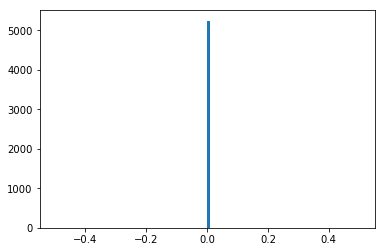

In [11]:
degree_sequence_gc=sorted(nx.degree(gc, weight = 'weight'),key=lambda d: d[1],reverse=True) #weighted degree distribution
s=[]
for i in degree_sequence_gc:
    s.append(i[1])
degree_sequence_gc=s  # make a few changes for compatible problems
degree_sequence_G=sorted(nx.degree(G, weight = 'weight'),key=lambda d: d[1],reverse=True) #weighted degree distribution
s=[]
for i in degree_sequence_G:
    s.append(i[1])
degree_sequence_G=s    # make a few changes for compatible problems
plt.hist(np.array(degree_sequence_gc)-np.array(degree_sequence_G),bins=100);
print sum(np.array(degree_sequence_gc)-np.array(degree_sequence_G))
print('My gc network has {} nodes.'.format(len(gc.nodes())))
print('G network has {} nodes.'.format(len(G.nodes())))

**Your answer here.**  They are identical,the difference between them only have zero.Below are the degree distribution individually.If they are different,probably because that unfortunately, the last few stubs just belong to one node.So we've dropped them,which causes the difference.

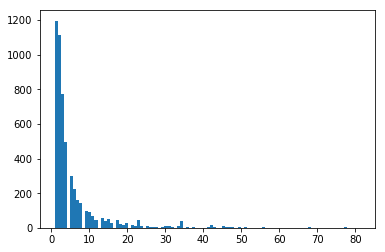

In [12]:
plt.hist(np.array(degree_sequence_gc),bins=100);

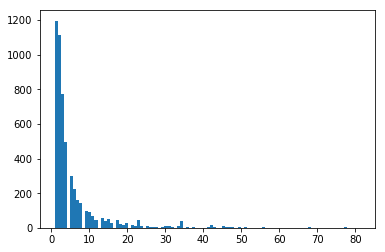

In [13]:
plt.hist(np.array(degree_sequence_G),bins=100);

2.3 Should these two networks have the same adjacency matrices? Justify.

**Your answer here.**  The greedy algorithm makes the high degree node connect easily.It sort the node by degree, 
and connect the high degree node first.So the edge mostly lies in a corner of the adjacency matrix.They are not the same.

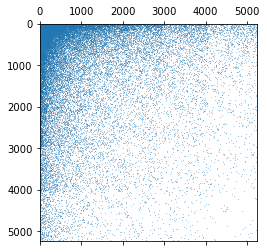

In [14]:
gc_adj = nx.adjacency_matrix(gc)
gc_adj = gc_adj.todense()
plt.spy(gc_adj,markersize=0.1)

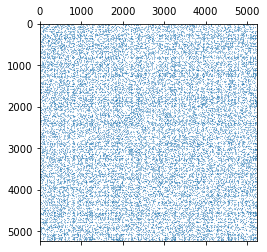

In [15]:
G_adj = nx.adjacency_matrix(G)
G_adj = G_adj.todense()
plt.spy(G_adj,markersize=0.1)

2.4 Draw both the generated and original networks. Are they similar? If not, why? Try to explain.

**Your answer here.**  No, the algorithom only guarantee the distribution of the degree is the similar, but it didn't restrict the connection of the node.So the adjacency matrix have no reason to be the same.In fact, we give the high priorty to the node which has high degree,and this priorty isn't exist when we form the real network.When we have high priorty to satisfy the degree the high degree node, then every node have a high probility to connect the high degree node in the graph.So this will form a very huge giant conponment and only a few node could run away from that.So it makes it quite different in the picture.

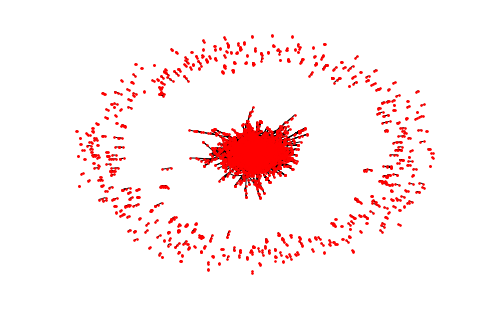

In [16]:
nx.draw(G,node_shape=".",node_size=10)

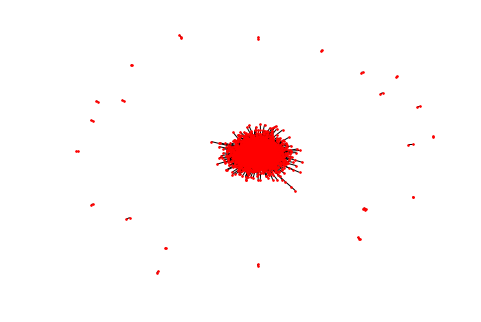

In [17]:
nx.draw(gc,node_shape=".",node_size=10)

2.5 Do you expect the properties studied in the first part of the assignment to be close to the original graph? Justify.

**Your answer here.**   They are have the same number of nodes.But since the greedy algorithm have weight of the edge,so it generate a graph with less edges.For giant component,as we talked before,greedy algorithm tend to generate larger giant component,we can see 5192 nodes are in the giant component, and the network have only 5242 nodes.Cluster coefficient is far from the same,real network have really large cluster coefficient than random model.

In [18]:
print('My G network has {} nodes.'.format(len(G.nodes())))
print('My G network has {} edges.'.format(G.size()))
print('My gc has {} nodes.'.format(len(gc.nodes())))
print('My gc network has {} edges.'.format(gc.size()))

My G network has 5242 nodes.
My G network has 14496 edges.
My gc has 5242 nodes.
My gc network has 14421 edges.


In [19]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_gc = max(nx.connected_component_subgraphs(gc), key=len)
print(len(giant_G.nodes()))
print(len(giant_gc.nodes()))

4158
5194


In [20]:
print (nx.average_clustering(G))
print (nx.average_clustering(gc))

0.529635811052
0.00628204261559
